In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


In [2]:
owid_data = pd.read_csv("./1_owid/owid-covid-data.csv")

In [3]:
owid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58154 entries, 0 to 58153
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso_code                            57821 non-null  object 
 1   continent                           57472 non-null  object 
 2   location                            58154 non-null  object 
 3   date                                58154 non-null  object 
 4   total_cases                         57611 non-null  float64
 5   new_cases                           57604 non-null  float64
 6   new_cases_smoothed                  56649 non-null  float64
 7   total_deaths                        49288 non-null  float64
 8   new_deaths                          49287 non-null  float64
 9   new_deaths_smoothed                 56649 non-null  float64
 10  total_cases_per_million             57278 non-null  float64
 11  new_cases_per_million               57271

In [4]:
owid_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'total_vaccinations_per_hundred', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'ag

In [5]:
data = owid_data.dropna(subset=["total_cases"])
data = data.loc[data['continent'] == "Asia"]
# to ensure that we didn't use future data in prediction
data_sort = data.sort_values(by=["date"])
# drop columns that are all NaNs
data_sort = data_sort.dropna(axis=1, how='all')
data_sort.shape

(14546, 44)

In [6]:
drop_cols = ["iso_code", "continent", "location", "tests_units"]
data_sort.fillna(0, inplace=True)
data_sort.info()
data_sort = data_sort.drop(columns=drop_cols)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14546 entries, 26387 to 57584
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         14546 non-null  object 
 1   continent                        14546 non-null  object 
 2   location                         14546 non-null  object 
 3   date                             14546 non-null  object 
 4   total_cases                      14546 non-null  float64
 5   new_cases                        14546 non-null  float64
 6   new_cases_smoothed               14546 non-null  float64
 7   total_deaths                     14546 non-null  float64
 8   new_deaths                       14546 non-null  float64
 9   new_deaths_smoothed              14546 non-null  float64
 10  total_cases_per_million          14546 non-null  float64
 11  new_cases_per_million            14546 non-null  float64
 12  new_cases_smoo

In [7]:
data_sort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14546 entries, 26387 to 57584
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             14546 non-null  object 
 1   total_cases                      14546 non-null  float64
 2   new_cases                        14546 non-null  float64
 3   new_cases_smoothed               14546 non-null  float64
 4   total_deaths                     14546 non-null  float64
 5   new_deaths                       14546 non-null  float64
 6   new_deaths_smoothed              14546 non-null  float64
 7   total_cases_per_million          14546 non-null  float64
 8   new_cases_per_million            14546 non-null  float64
 9   new_cases_smoothed_per_million   14546 non-null  float64
 10  total_deaths_per_million         14546 non-null  float64
 11  new_deaths_per_million           14546 non-null  float64
 12  new_deaths_smo

In [8]:
data_grouped = data.groupby(["date"]).sum()
print(data_grouped)
data_sort = data_grouped

            total_cases  new_cases  new_cases_smoothed  total_deaths  \
date                                                                   
2020-01-22        554.0        0.0               0.000          17.0   
2020-01-23        653.0       99.0               0.000          18.0   
2020-01-24        937.0      284.0               0.000          26.0   
2020-01-25       1429.0      492.0               0.000          42.0   
2020-01-26       2105.0      676.0               0.000          56.0   
...                 ...        ...                 ...           ...   
2020-12-31   20695037.0    65469.0           76282.716      337412.0   
2021-01-01   20771126.0    76089.0           74869.715      338561.0   
2021-01-02   20860993.0    89867.0           76882.573      339909.0   
2021-01-03   20930526.0    69533.0           76602.143      340970.0   
2021-01-04   21003980.0    73454.0           77071.999      342075.0   

            new_deaths  new_deaths_smoothed  total_cases_per_mi

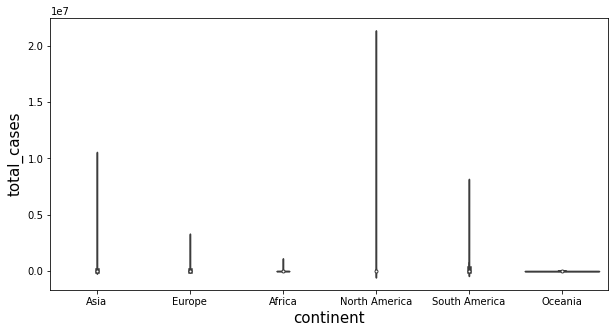

In [9]:
plt.figure(figsize=(10,5))
sns.violinplot(x = owid_data.continent, y=owid_data['total_cases'])
plt.xlabel('continent',fontsize=15)
plt.ylabel('total_cases',fontsize=15)
plt.show()

### ARIMA Model

In [10]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['total_cases'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

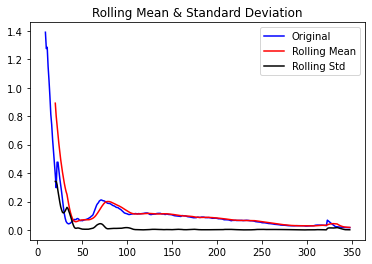

ADF Statistic: -2.3465278461654067
p-value: 0.15740041370503205
Critical Values:
	1%: -3.4504451681828194
	5%: -2.870392380216117
	10%: -2.571486353732897


In [11]:
df_log = pd.DataFrame(np.log(data_sort["total_cases"].values), columns=["total_cases"])
rolling_mean = df_log.rolling(window=10).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

> Use the original format

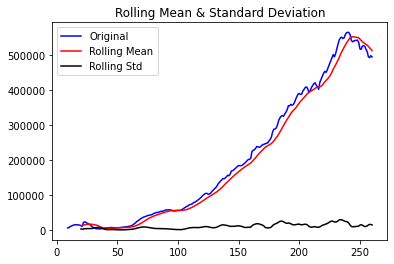

ADF Statistic: -0.8268648750029731
p-value: 0.8111030772931684
Critical Values:
	1%: -3.4584868856997004
	5%: -2.873918902362675
	10%: -2.573367247623359


In [12]:
train_size = int(data_sort.shape[0]*0.75)
df = data_sort[["total_cases"]].reset_index(drop=True).iloc[:train_size]
df_rolling_mean = df.rolling(window=10).mean()
df_minus_mean = df - df_rolling_mean
df_minus_mean.dropna(inplace=True)
get_stationarity(df_minus_mean)

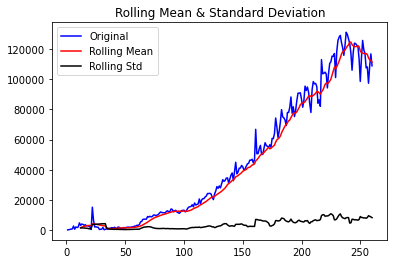

ADF Statistic: -0.8259787265513332
p-value: 0.8113716655530221
Critical Values:
	1%: -3.457437824930831
	5%: -2.873459364726563
	10%: -2.573122099570008


In [13]:
df_shift = df - df.shift()
df_shift.dropna(inplace=True)
get_stationarity(df_shift)

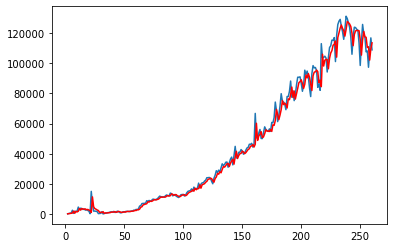

In [14]:
model = ARIMA(df, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_shift[1:])
plt.plot(results.fittedvalues[1:], color='red')

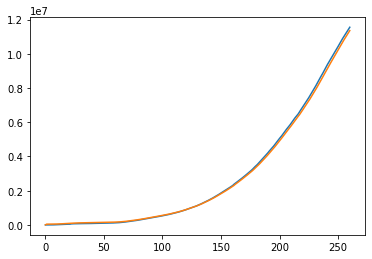

In [15]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(df["total_cases"].iloc[0], index=df.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
plt.plot(df)
plt.plot(predictions_ARIMA)

In [16]:
print(mean_squared_error(df, predictions_ARIMA, squared=False))

102018.89955997656


In [17]:
pred = results.predict(start=train_size, end = len(data_sort)-1)
predictions_ARIMA_diff = pd.Series(pred, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(df["total_cases"].iloc[-1], index=predictions_ARIMA_diff_cumsum.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)

In [18]:
print(mean_squared_error(data_sort[["total_cases"]].reset_index(drop=True).iloc[train_size:], predictions_ARIMA, squared=False))

391123.8241275733


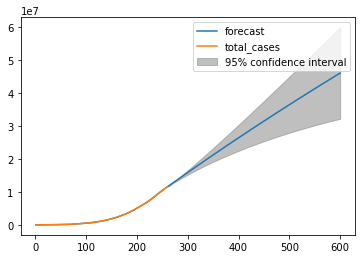

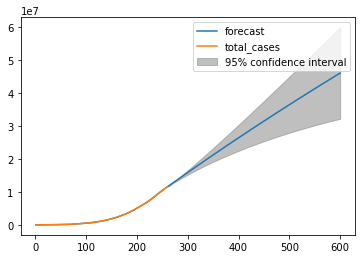

In [19]:
results.plot_predict(1, 600)

### Models Using Multiple Columns - Regression and GBDT Model

> Notes: "iso_code": because it's same as location. Fillna: "total_vaccinations", "total_vaccinations_per_hundred" with 0.

In [20]:
data_model = data_sort.copy()
y_values = data_model['total_cases'].values[1:]
# drop_cols = ['iso_code', 'location', 'date']

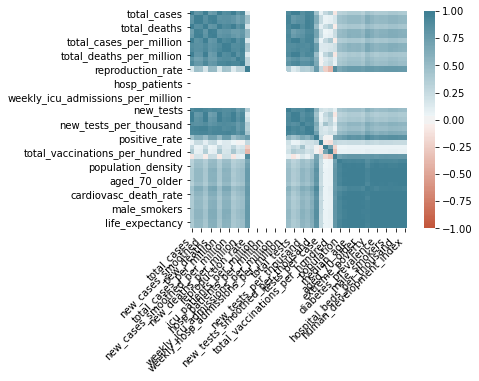

In [21]:
corr = data_model[[i for i in data_model.columns]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#ax.set_title('Correlation matrix',fontsize=15)
plt.savefig('corr_worldwide.png')

In [22]:
data_model[["total_vaccinations", "total_vaccinations_per_hundred", "reproduction_rate",
           "new_cases_smoothed", "new_cases_smoothed_per_million", "new_deaths_smoothed",
           "new_deaths_smoothed_per_million"]].describe()

,total_vaccinations,total_vaccinations_per_hundred,reproduction_rate,new_cases_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed,new_deaths_smoothed_per_million
count,3.490000e+02,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,4.097485e+04,0.373324,34.741891,57169.159166,1759.996625,970.167794,18.765550
std,3.313944e+05,2.095268,16.173709,44050.046731,1270.205943,635.321981,15.995403
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,36.520000,11899.143000,533.627000,346.717000,5.557000
50%,0.000000e+00,0.000000,42.280000,55652.284000,1799.880000,1168.002000,16.850000
75%,0.000000e+00,0.000000,44.330000,95514.715000,2472.014000,1547.858000,28.317000
max,5.512798e+06,17.880000,50.320000,129000.998000,4400.716000,1850.861000,49.976000


In [23]:
# data_model.fillna(0, inplace=True)
# data_model.info()
x_values = data_model.iloc[:-1]
print(data_model.columns)
print(y_values.shape)
print(x_values.shape)

Index(['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'total_vaccinations_per_hundred', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiova

In [24]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from gap_statistic import OptimalK

In [25]:
def plot_clusters(full_data, group_col):
    
    # seperate features only from cluster labels
    feature_columns = [colname for colname in list(full_data.columns) if 'Cluster' not in colname]
    features_only = full_data[feature_columns]

    # fit PCA to the whole data
    fitted_pca = PCA().fit(features_only)

    # take a sample of the whole data
    df_sample = features_only.sample(full_data.shape[0], random_state=109)
#     df_sample = full_data

    # apply the PCA transform on the sample
    pca_sample = pd.DataFrame(fitted_pca.transform(df_sample), columns = ["PCA{}".format(i) for i in range(len(df_sample.columns.values))])
    pca_sample.index = df_sample.index
    
    # re-include a cluster label for the pca data
    pca_sample[group_col] = full_data.loc[pca_sample.index, group_col]
    
    plt.figure(figsize=(11,8.5))
    marker_types = [".", "v", "1", "^", "s", "p", "P", "3", "H", "<", "|", "_", "x", "*","d","X"]
    marker_colors = np.concatenate([np.array(plt.cm.tab10.colors),np.array(plt.cm.Pastel1.colors)])
    
    for i, (cluster_id, cur_df) in enumerate(pca_sample.groupby([group_col])):

        pca1_scores = cur_df.iloc[:,0]
        pca2_scores = cur_df.iloc[:,1]
        plt.scatter(pca1_scores, pca2_scores, label=cluster_id, c=marker_colors[i].reshape(1,-1), marker=marker_types[i])

    plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
    plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
    plt.legend()
    plt.show()
    return pca_sample

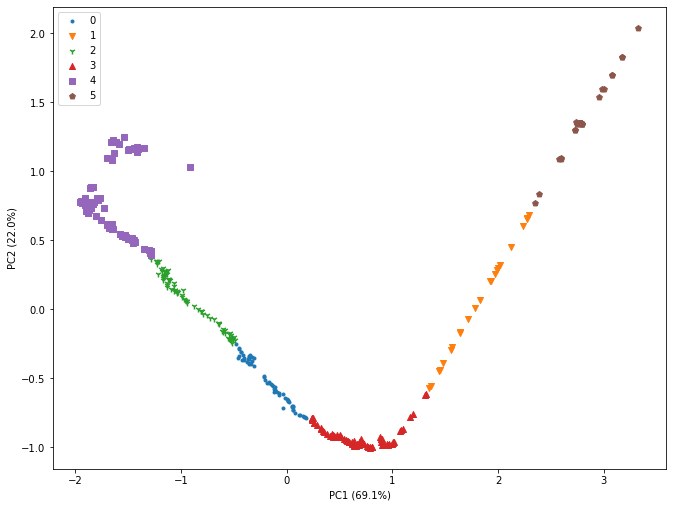

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA38,PCA39,PCA40,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,Cluster6
328,-1.790511,0.810269,0.245209,-0.223308,-0.124354,0.001809,0.016550,0.045126,0.097304,0.067602,...,-0.000013,-2.562174e-16,2.463000e-17,4.206246e-16,-6.247088e-17,1.142663e-16,-6.563806e-17,3.118959e-17,-3.426215e-16,4
1,3.174817,1.829016,-0.362020,-0.308476,-0.035346,0.080794,0.170365,0.100986,0.006673,0.012075,...,0.000180,4.612285e-16,2.019979e-16,-5.532349e-16,1.627028e-16,-5.637602e-16,7.892230e-16,1.437531e-16,-1.969151e-16,5
227,-0.800174,-0.014184,-0.432138,0.350976,-0.012739,0.027458,0.045221,-0.003177,-0.041027,0.024071,...,-0.000011,-2.233080e-16,-6.632473e-17,1.621278e-16,2.530564e-17,8.623054e-17,-9.771131e-17,-3.568407e-17,-1.511583e-16,2
341,-1.474473,1.160158,1.022541,0.295737,0.278657,0.095973,0.054681,0.158089,-0.117912,-0.000667,...,0.000035,-1.740127e-17,1.675914e-16,4.127378e-16,1.185382e-16,2.838039e-16,6.965861e-17,-5.148571e-17,-4.653860e-16,4
28,2.725985,1.300555,-0.161816,-0.050456,0.069687,0.099932,-0.083671,0.014473,0.001001,-0.017093,...,-0.000028,3.766849e-16,1.566092e-16,-6.031232e-16,2.055993e-16,-3.462298e-16,6.609014e-16,8.527954e-17,-1.669655e-16,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.898671,-0.944800,0.179735,0.035790,-0.227122,-0.057712,0.064625,0.119450,0.025793,-0.015810,...,0.000255,2.231623e-16,-5.080511e-17,-2.567544e-16,-5.734761e-18,-1.818572e-17,-7.682098e-17,4.466241e-17,2.316077e-16,3
141,0.163647,-0.780163,0.012106,-0.247055,0.169080,0.036933,0.054781,-0.105303,-0.018625,0.013443,...,0.000020,-1.932082e-17,-4.170803e-17,-7.696798e-17,-6.445458e-17,-2.905298e-17,-1.683903e-16,-3.382884e-17,1.714713e-16,0
347,-1.345800,1.167273,1.212052,0.445027,0.387333,0.161303,0.315053,0.141953,0.231447,0.216061,...,-0.000051,-3.792431e-17,1.414215e-16,4.046477e-16,1.511196e-16,2.736424e-16,1.563944e-16,-9.720582e-17,-4.122194e-16,4
245,-1.088435,0.146533,-0.496799,0.283092,0.033470,0.216993,-0.167159,-0.008005,0.072899,0.071125,...,0.000047,-2.969399e-16,-4.541037e-17,2.444168e-16,8.251237e-18,6.870108e-17,-7.781215e-17,1.079669e-17,-8.198008e-17,2


In [26]:
scaler = MinMaxScaler()
data_mod = data_model
scaler.fit(data_mod)
df_process = scaler.transform(data_mod)
df_process = pd.DataFrame(df_process, columns = data_mod.columns)

km6 = KMeans(n_clusters=6, n_init=46, random_state=109).fit(df_process)
df_process['Cluster6'] = km6.labels_
plot_clusters(df_process, 'Cluster6')

In [27]:
train_size = int(x_values.shape[0]*0.75)
x_train = x_values.iloc[:train_size]
x_test = x_values.iloc[train_size:]
y_train = y_values[:train_size]
y_test = y_values[train_size:]

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result_df = pd.DataFrame()
lr = LinearRegression().fit(x_train, y_train)

lr_train_acc = mean_squared_error(y_train, lr.predict(x_train), squared=False)
lr_test_acc = mean_squared_error(y_test, lr.predict(x_test), squared=False)

print('Baseline regression: RMSE on train set is ', str(round(lr_train_acc,4)))
print('Baseline regression: RMSE on test set is ', str(round(lr_test_acc,4)))

Baseline regression: RMSE on train set is  3905.3134
Baseline regression: RMSE on test set is  95351.905


In [29]:
from sklearn.metrics import r2_score
print(r2_score(y_train, lr.predict(x_train)))
print(r2_score(y_test, lr.predict(x_test)))

0.9999986541465377
0.9988959127781215


In [30]:
lr.coef_

array([ 9.83973289e-01,  6.62467389e-02,  9.17849612e-01,  1.27556081e+00,
        3.52994540e+00, -1.28685736e+01, -1.37995520e-01,  4.72937167e+00,
       -9.58349633e+00, -1.45868590e+01, -6.81553356e+01,  2.57961465e+02,
        4.34286676e+02,  8.60845365e-07, -4.33292390e-06, -4.64142865e-07,
        1.62648469e-07,  4.14291630e-07, -2.37638965e-07, -3.49560025e-09,
        2.48362255e-08,  8.53943501e-03,  1.47171953e-05,  1.79658349e+00,
        6.95271741e+01, -1.03798121e-02,  3.03743054e+02,  5.36920144e+02,
       -3.09017859e-02,  3.82311782e-09, -4.63046490e-10, -1.31253512e+01,
       -6.98775494e-07,  1.14187732e-01, -4.24512781e+02,  5.81757731e+02,
       -1.02357712e+03,  1.47110168e-02, -1.47827203e+02,  3.35287273e+00,
       -2.30420754e+02, -4.16701597e+01,  9.99137479e+01,  1.55641882e+01,
       -5.63741820e+02,  1.17086476e+02,  4.44416393e+03])

In [31]:
sub_col = ["total_cases", 'reproduction_rate',
       'total_vaccinations', 'total_vaccinations_per_hundred', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy']

In [32]:
from sklearn.preprocessing import PolynomialFeatures

inters= PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
x_interaction_train = inters.fit_transform(x_train)
x_interaction_train_df = pd.DataFrame(x_interaction_train,columns = inters.get_feature_names(x_train.columns))

x_interaction_test = inters.fit_transform(x_test.copy())
x_interaction_test_df = pd.DataFrame(x_interaction_test,columns= inters.get_feature_names(x_test.columns))

In [33]:
lr_inter = LinearRegression().fit(x_interaction_train_df,y_train)

inter_train_acc = mean_squared_error(y_train, lr_inter.predict(x_interaction_train_df), squared=False)
inter_test_acc = mean_squared_error(y_test, lr_inter.predict(x_interaction_test_df), squared=False)

print('Linear regression with interaction term: RMSE on train set is ', str(round(inter_train_acc,4)))
print('Linear regression with interaction term: RMSE on test set is ', str(round(inter_test_acc,4)))

Linear regression with interaction term: RMSE on train set is  45.4392
Linear regression with interaction term: RMSE on test set is  19709768.6054


> Simple Decision Tree with max depth = 3

In [34]:
from sklearn.tree import DecisionTreeClassifier
tree0 = DecisionTreeClassifier(max_depth=3)
tree0.fit(x_train, y_train)
y_pred_test = tree0.predict(x_test)
y_pred_train = tree0.predict(x_train)
acc_test_tree = mean_squared_error(y_test, y_pred_test, squared=False)

acc_train_tree = mean_squared_error(y_train,y_pred_train, squared=False)

print("Decision Tree RMSE in train set is: " + str(round(acc_train_tree, 4)))
print("Decision Tree RMSE in test set is: " + str(round(acc_test_tree, 4)))

Decision Tree RMSE in train set is: 4390893.9866
Decision Tree RMSE in test set is: 16487605.4593


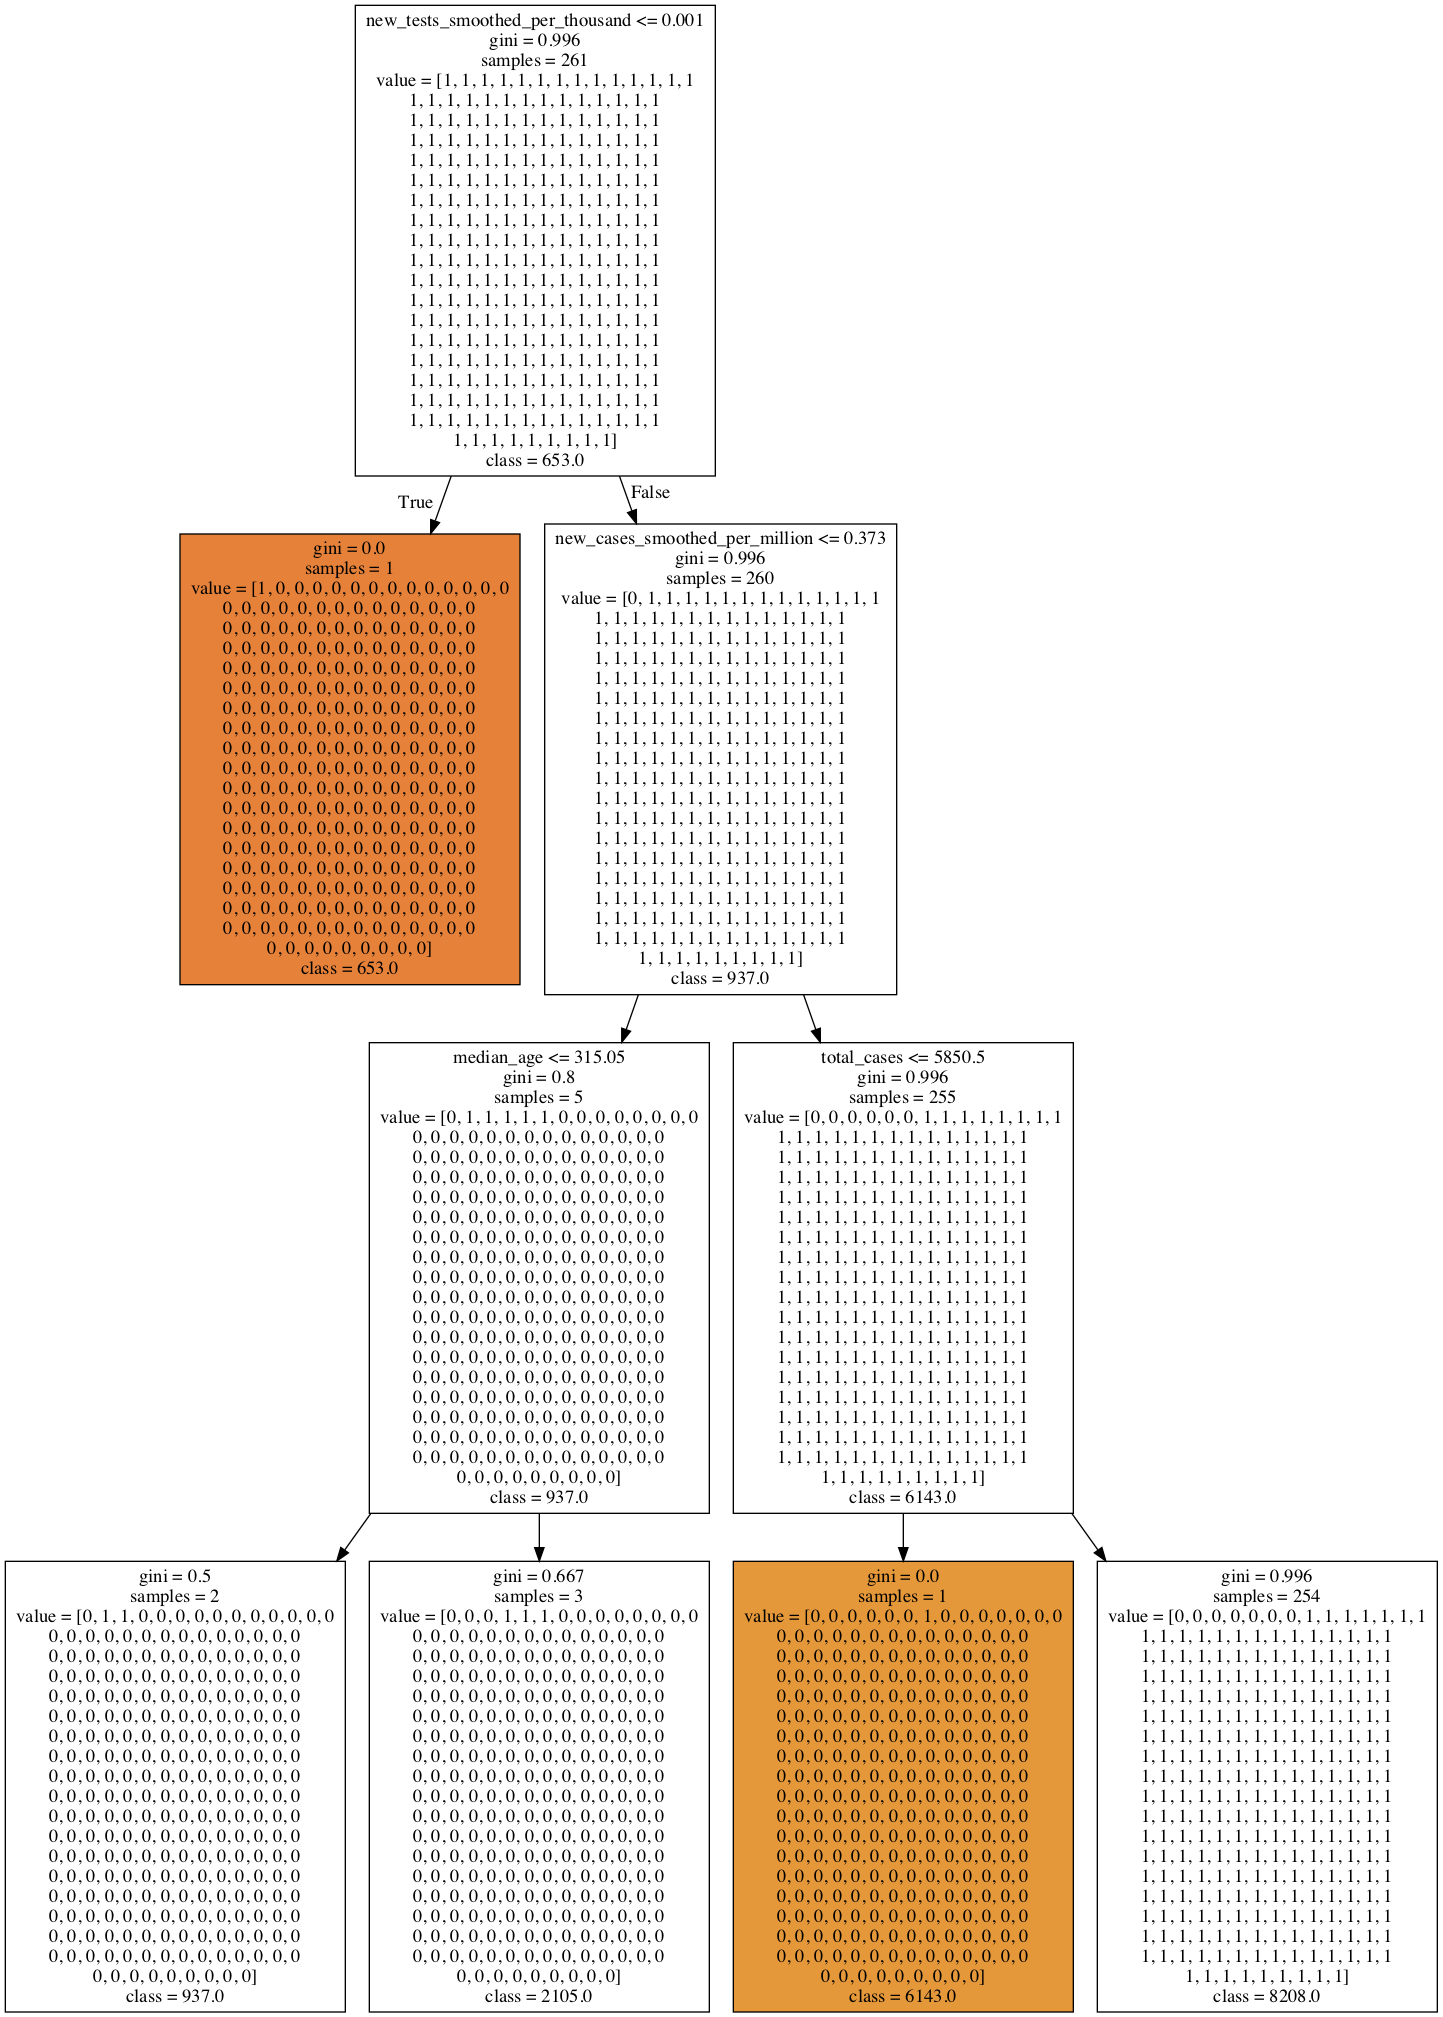

In [35]:
import pydotplus
import sklearn.tree as tree
from IPython.display import Image

dt_feature_names = list(x_train.columns)
dt_target_names = [str(s) for s in y_train]
tree.export_graphviz(tree0, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train, y_train, train_size=0.85, random_state=1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train.columns))
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train.columns))
model2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1500, verbose_eval=False)
y_pred_train = model2.predict(x_train, num_iteration=model2.best_iteration)
acc_lgb_train = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model2.predict(x_test, num_iteration=model2.best_iteration)
acc_lgb_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("RMSE in train set is: " + str(round(acc_lgb_train, 4)))
print("RMSE in test set is: " + str(round(acc_lgb_test, 4)))

RMSE in train set is: 137056.4033
RMSE in test set is: 7053589.9398


Text(0, 0.5, 'Features')

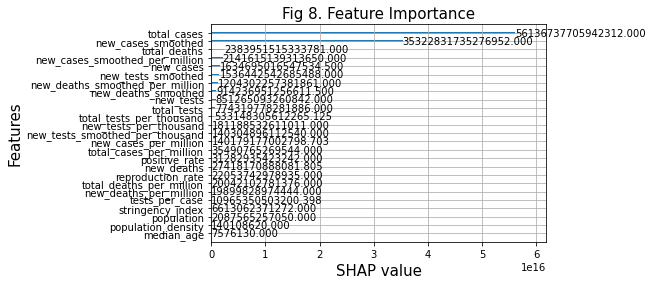

In [37]:
lgb.plot_importance(model2, importance_type="gain")
plt.title('Fig 8. Feature Importance',fontsize = 15)
plt.xlabel('SHAP value',fontsize=15)
plt.ylabel('Features',fontsize=15)

In [38]:
import shap
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(x_train)

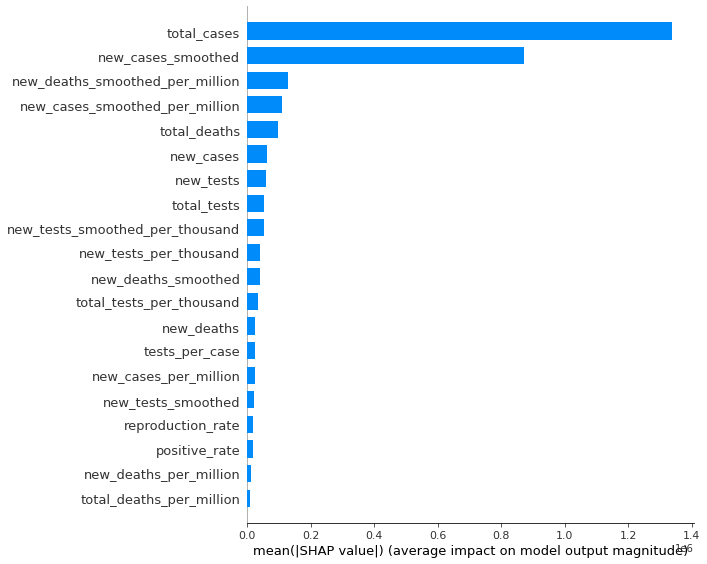

In [39]:
shap.summary_plot(shap_values, x_train, plot_type="bar", feature_names=x_train.columns)

In [40]:
shap_interaction_values = shap.TreeExplainer(model2).shap_interaction_values(x_train)

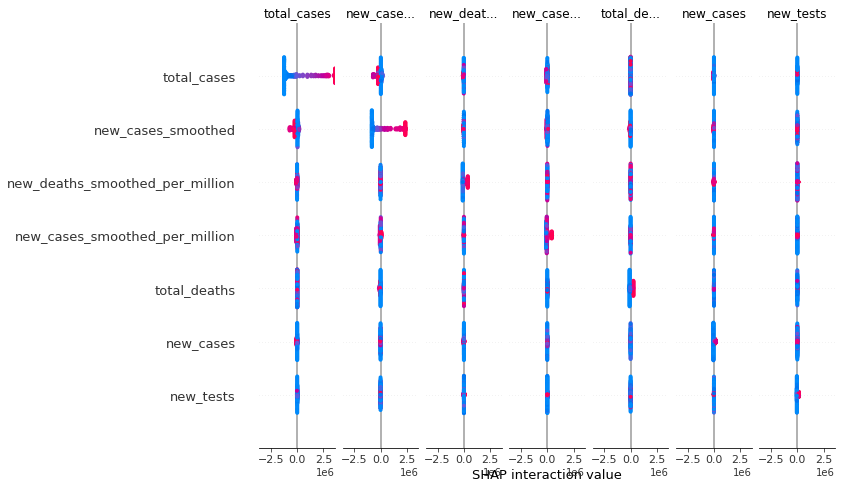

In [41]:
shap.summary_plot(shap_interaction_values,x_train,feature_names=x_train.columns)

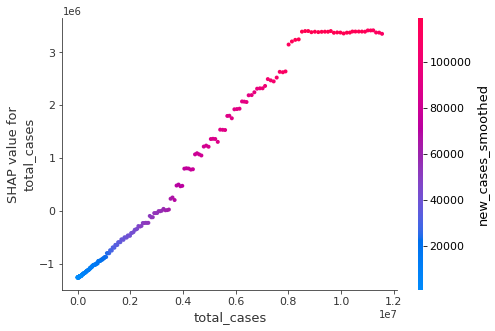

In [42]:
shap.dependence_plot("total_cases", shap_values, x_train, interaction_index='new_cases_smoothed',feature_names=x_train.columns)

In [43]:
variable_drop = []
accs_train_gbm = []
accs_test_gbm = []
accs_train_logis = []
accs_test_logis = []
accs_train_logis_l2 = []
accs_test_logis_l2 = []

for i in range(47):
    print(i)
    df_temp_train = x_train.copy()
    df_temp_test = x_test.copy()
    if i > 0:
        x_train_feature = df_temp_train.drop(variable_drop, axis=1)
        x_test_feature = df_temp_test.drop(variable_drop, axis=1)
    else:
        x_train_feature = df_temp_train.copy()
        x_test_feature = df_temp_test.copy()
    x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train_feature, y_train, train_size=0.85, random_state=1)
    params = {
      'boosting_type': 'gbdt',
      'objective': 'regression',
      'learning_rate': 0.01,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.9,
      'bagging_freq': 5,
      'max_depth': 100,
      'seed': 1
    }
    lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train_feature.columns))
    lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train_feature.columns))
    model_fea = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                  valid_names=["train", "eval"], early_stopping_rounds=1500, verbose_eval=False)
    y_pred_lgb_train = model_fea.predict(x_train_feature, num_iteration=model_fea.best_iteration)
    acc_lgb_train = mean_squared_error(y_train, y_pred_lgb_train, squared=False)

    y_pred_lgb_test = model_fea.predict(x_test_feature, num_iteration=model_fea.best_iteration)
    acc_lgb_test = mean_squared_error(y_test, y_pred_lgb_test,squared=False)
    accs_train_gbm.append(acc_lgb_train)
    accs_test_gbm.append(acc_lgb_test)
    lr = LinearRegression().fit(x_train_feature, y_train)
    accs_train_logis_l2.append(mean_squared_error(y_train, lr.predict(x_train_feature), squared=False))
    accs_test_logis_l2.append(mean_squared_error(y_test, lr.predict(x_test_feature), squared=False))

    # drop
    explainer = shap.TreeExplainer(model_fea)
    shap_values = explainer.shap_values(x_train_feature)
    mean_shap_feature_values = pd.DataFrame(shap_values, 
                                          columns=x_train_feature.columns).abs().mean(axis=0).sort_values(ascending=False)
    variable_drop.append(list(mean_shap_feature_values.index)[-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


> ML performs not very well; small data points; maybe groupedby continent would be better

In [44]:
print(accs_test_logis_l2)
print(len(accs_test_logis_l2))

[95351.90501399033, 95396.39190352384, 95172.3446393293, 94994.8034375566, 94937.55998596159, 93366.69192839514, 93366.69192841309, 92695.90459363443, 92695.9045937747, 92737.52443739201, 92737.52443739957, 92816.47717250473, 92816.47717464642, 92687.39186856648, 92687.39187294096, 92929.73301489708, 92929.73289990125, 92950.22696203242, 92950.22722296922, 92206.29841782681, 92206.2984132499, 92289.12497284937, 92289.12498852829, 92289.12498851304, 92430.56577875088, 92988.50251749072, 92520.77121026738, 92520.31807946369, 86195.39359939749, 86156.06035882453, 86279.08900729867, 86285.73679778432, 86236.73634160383, 86172.3202330537, 86112.30654344274, 86126.71385835664, 86336.77813468956, 86353.95517586404, 86332.18511428408, 86407.3419172723, 86801.3601407484, 87807.46681935719, 86889.10832900398, 87708.95233649372, 87669.11384324702, 87889.8506039044, 136052.0422383932]
47


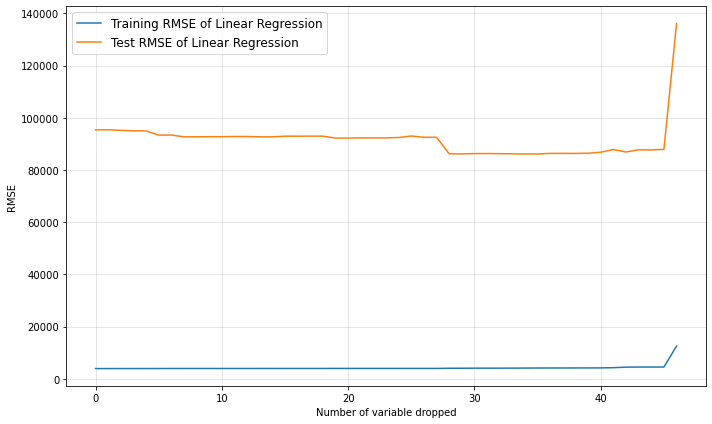

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(range(len(accs_train_gbm)), accs_train_gbm, label="Training RMSE of LightGBM")
# ax.plot(range(len(accs_train_gbm)), accs_test_gbm, label="Test RMSE of LightGBM")
ax.plot(range(len(accs_train_gbm)), accs_train_logis_l2, label="Training RMSE of Linear Regression")
ax.plot(range(len(accs_train_gbm)), accs_test_logis_l2, label="Test RMSE of Linear Regression")
plt.legend(fontsize=12)
plt.xlabel("Number of variable dropped")
plt.ylabel("RMSE")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

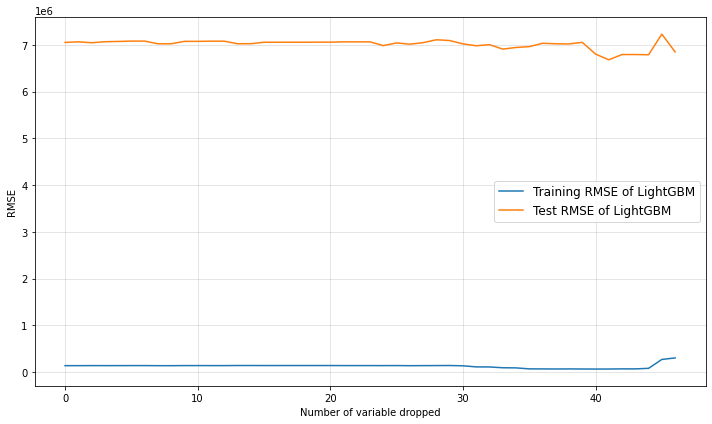

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(accs_train_gbm)), accs_train_gbm, label="Training RMSE of LightGBM")
ax.plot(range(len(accs_train_gbm)), accs_test_gbm, label="Test RMSE of LightGBM")
# ax.plot(range(len(accs_train_gbm)), accs_train_logis_l2, label="Training RMSE of Linear Regression")
# ax.plot(range(len(accs_train_gbm)), accs_test_logis_l2, label="Test RMSE of Linear Regression")
plt.legend(fontsize=12)
plt.xlabel("Number of variable dropped")
plt.ylabel("RMSE")
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

In [47]:
print(accs_train_gbm)

[137056.40329345994, 137075.6686171303, 138247.86077013187, 137862.76190777493, 138093.9909364907, 138703.57601468844, 138703.57601468844, 136698.46159121383, 136698.46159121383, 138684.60260480118, 138684.60260480118, 138351.4338807539, 138351.4338807539, 140168.10393850508, 140168.10393850508, 139404.36761707536, 139404.36761707536, 139757.16670997653, 139757.16670997653, 139726.49171721807, 139726.49171721807, 138679.43117443874, 138679.43117443874, 138679.43117443874, 138132.34930598282, 139076.6638723368, 136250.53164868298, 138033.3480214819, 138918.73924009257, 140355.35573524033, 134113.41928544088, 110921.66711478909, 109301.58966977241, 92310.43720350592, 89354.99538800263, 68437.03416509813, 67427.99363704168, 65906.64642635258, 67340.2211456898, 65635.16865714046, 64453.94837988007, 65238.35752416892, 68318.39709685248, 68318.39709685248, 79961.39326874062, 270033.8440769452, 302540.4911815874]


In [48]:
print(variable_drop)
print(len(variable_drop))

['human_development_index', 'life_expectancy', 'hospital_beds_per_thousand', 'handwashing_facilities', 'male_smokers', 'weekly_hosp_admissions_per_million', 'female_smokers', 'weekly_hosp_admissions', 'diabetes_prevalence', 'weekly_icu_admissions_per_million', 'cardiovasc_death_rate', 'weekly_icu_admissions', 'extreme_poverty', 'hosp_patients_per_million', 'gdp_per_capita', 'hosp_patients', 'aged_70_older', 'icu_patients_per_million', 'aged_65_older', 'icu_patients', 'median_age', 'total_vaccinations_per_hundred', 'total_vaccinations', 'population_density', 'population', 'new_tests_smoothed', 'total_cases_per_million', 'stringency_index', 'total_deaths_per_million', 'new_deaths_per_million', 'reproduction_rate', 'positive_rate', 'tests_per_case', 'new_cases_per_million', 'new_deaths', 'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'new_tests_per_thousand', 'total_tests', 'new_deaths_smoothed', 'new_cases', 'new_tests', 'total_deaths', 'new_cases_smoothed_per_million', '

In [49]:
val_list = ['new_tests', 'total_deaths', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'new_cases_smoothed', 'total_cases']

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

x_train_gbm, x_val_gbm, y_train_gbm, y_val_gbm = train_test_split(x_train[val_list], y_train, train_size=0.85, random_state=1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'max_depth': 100,
    'seed': 1
}
lgb_train = lgb.Dataset(x_train_gbm, y_train_gbm, feature_name=list(x_train[val_list].columns))
lgb_eval = lgb.Dataset(x_val_gbm, y_val_gbm, feature_name=list(x_train[val_list].columns))
model2 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=[lgb_train, lgb_eval], 
                valid_names=["train", "eval"], early_stopping_rounds=1500, verbose_eval=False)
y_pred_train = model2.predict(x_train[val_list], num_iteration=model2.best_iteration)
acc_lgb_train = mean_squared_error(y_train, y_pred_train, squared=False)

y_pred_test = model2.predict(x_test[val_list], num_iteration=model2.best_iteration)
acc_lgb_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("RMSE in train set is: " + str(round(acc_lgb_train, 4)))
print("RMSE in test set is: " + str(round(acc_lgb_test, 4)))

RMSE in train set is: 62801.967
RMSE in test set is: 6584904.104


In [50]:
val_list = ['new_cases_smoothed', 'total_cases']
lr = LinearRegression().fit(x_train[val_list], y_train)

lr_train_acc = mean_squared_error(y_train, lr.predict(x_train[val_list]), squared=False)
lr_test_acc = mean_squared_error(y_test, lr.predict(x_test[val_list]), squared=False)

print('Baseline regression: RMSE on train set is ', str(round(lr_train_acc,4)))
print('Baseline regression: RMSE on test set is ', str(round(lr_test_acc,4)))

Baseline regression: RMSE on train set is  4485.5974
Baseline regression: RMSE on test set is  87889.8506


In [51]:
from sklearn.linear_model import Lasso
lr = Lasso().fit(x_train[val_list], y_train)

lr_train_acc = mean_squared_error(y_train, lr.predict(x_train[val_list]), squared=False)
lr_test_acc = mean_squared_error(y_test, lr.predict(x_test[val_list]), squared=False)

print('Baseline regression: RMSE on train set is ', str(round(lr_train_acc,4)))
print('Baseline regression: RMSE on test set is ', str(round(lr_test_acc,4)))

Baseline regression: RMSE on train set is  4485.6334
Baseline regression: RMSE on test set is  87943.8071


In [52]:
from sklearn.linear_model import Ridge
lr = Ridge().fit(x_train[val_list], y_train)

lr_train_acc = mean_squared_error(y_train, lr.predict(x_train[val_list]), squared=False)
lr_test_acc = mean_squared_error(y_test, lr.predict(x_test[val_list]), squared=False)

print('Baseline regression: RMSE on train set is ', str(round(lr_train_acc,4)))
print('Baseline regression: RMSE on test set is ', str(round(lr_test_acc,4)))

Baseline regression: RMSE on train set is  4485.5974
Baseline regression: RMSE on test set is  87889.8506
